## Linear regression on the Boston House Prices dataset

In this exercise, you will perform linear regression on the Boston House Prices dataset.

This dataset contains median house prices in different areas around Boston. For each area, we have some information about it, that we will use as our features. We want to train a linear regression model that predicts the price of a house given the input features.

We don't have direct access to the dataset from PyTorch, but the `scikit` library provides a version of it.

An important part of the exercise will be to get used to process input dataset and translate it into a suitable format for your analysis.

In [102]:
# Import dataset
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

dataset = load_boston()

In [103]:
print(dataset['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Play around with the `dataset` variable to see what it contains. It is a *dictionary*, i.e. a Python structure with key-value pairs, where the keys can be arbitrary objects --- usually strings. 

To access the item with key `key` from a dictionary `dictionary`, use the syntax `dictionary[key]`.

The `keys()` method of a dictionary returns the set of keys. To start, try `print()`ing the contents of the the `DESCR` key.

The data in the dataset are Numpy arrays. To convert them to PyTorch tensors, just pass the array as the single argument of the `torch.tensor()` function.

From this point, prepare the data to process it as done in the previous exercise.

## Tensor loading

In [104]:
tensor_data = torch.from_numpy(dataset['data'])
tensor_target = torch.from_numpy(dataset['target'])
if torch.cuda.is_available():
    tensor_data = tensor_data.to('cuda')
    tensor_target = tensor_target.to('cuda')


In [105]:
print(f'Data tensor size: {tensor_data.size()}\nTarget tensor size: {tensor_target.size()}')

Data tensor size: torch.Size([506, 13])
Target tensor size: torch.Size([506])


### Correlations

One of the things you may want to do is remove unnecessary features. For example, if you have two highly-correlated features, you could use only one of them.

Feature correlation can be estimated using the Pearson correlation coefficient:

$$\text{corr}_{X_1,X_2} = \frac{\text{cov}(X_1,X_2)}{\sigma_{X_1} \sigma_{X_2}}$$

where $\text{cov}(X_1,X_2)$ is the covariance between features $X_1$ and $X_2$ (i.e., all values for that feature, from all observations), and $\sigma_X$ is the standard deviation of feature $X$.

All values $X_i$ are basically the columns of our data matrix. Given the vector `X_i` that contains all values for a feature, you can use the `X_i.std()` function to get the standard deviation of that vector.

You can also use the variant of `std()` that takes an input `dim` argument to compute *all* standard deviations for each column in the full data matrix.

To compute the covariance matrix, you are going to need to perform some computations. This is a good training exercise to learn how to manipulate tensors, while will be very useful later.

Let's suppose your data matrix is `X`, where each row is an observation and each column is a feature.

First of all, you will need to compute a vector `X_mean`, where each element is the mean value for each feature. To do this, you will need to use the `torch.mean()` or the `Tensor.mean()` function.

From there, you have to subtract the mean vector to each observation in the data matrix. Note that PyTorch supports an operation called *broadcasting*. In practice, if `X` has size $n \times d$, and if `X_mean` has size $d$ or $1 \times d$, then `X - X_mean` will automatically subtract `X_mean` from each row in `X`.

Finally, if $N$ is the number of observation and `X_cent` is the data matrix where the mean vector has been subtracted, you can compute the covariance matrix $\Sigma$ as:

$$\Sigma = \frac{X_{\text{cent}}^T X_{\text{cent}}}{N-1}$$

Each element $\Sigma_{ij}$ is going to be equal to $\text{cov}(X_i,X_j)$. From those values and from the $\sigma_i$ values, you can compute the correlation matrix.

## Helper functions
Let's write some helper functions that we'll use later in the notebook.

In [106]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1] + 1) - .5, minor=True)
    ax.set_yticks(np.arange(data.shape[0] + 1) - .5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, double_sided_threshold=False, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    double_sided_threshold
        Toggle double-sided threshold.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None and not double_sided_threshold:
        threshold1 = im.norm(threshold)
    elif threshold is None:
        threshold1 = im.norm(data.max()) / 2.
    else:
        threshold1 = im.norm(threshold)
        threshold2 = im.norm(-threshold)

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[
                int(im.norm(data[i, j]) > threshold1 or (double_sided_threshold and im.norm(data[i, j]) < threshold2))])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


def format_func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")

In [107]:
def calculate_cov_mat(t_data, output_centered_mat=False):
    """
    Returns the Covariance matrix for the input tensor

    :param output_centered_mat: True if you want to output the subtracted-mean matrix, False otherwise
    :param t_data: the input tensor
    :return: the Covariance matrix
    """
    data_mean = t_data.mean(0)
    cent_mat = t_data - data_mean
    conj_cent_mat = cent_mat.T @ cent_mat
    cov_mat_ij = conj_cent_mat / (t_data.size(0) - 1)

    if output_centered_mat:
        return cov_mat_ij, cent_mat
    else:
        return cov_mat_ij

In [108]:
def calculate_corr_coef(t_cov_mat):
    f"""
    Returns the correlation coefficient matrix

    :param t_cov_mat: the input Covariance matrix (previously calculated)
    :return: the Correlation coefficient matrix
    """
    diagonal = t_cov_mat.diag()
    stddev = diagonal.sqrt()
    return t_cov_mat / stddev.view(-1, 1) / stddev.view(1, -1)

In [109]:
def plot_corr_matrix(corr_coeff_mat, feature_names):
    """
    Plot the correlation coefficient matrix

    :param corr_coeff_mat: the correlation coefficient matrix
    :param feature_names: the ordered feature names
    """
    _, ax = plt.subplots(figsize=(8, 6))
    im, _ = heatmap(corr_coeff_mat.to('cpu'), feature_names, feature_names, ax=ax, cmap='PuOr',
                    cbarlabel='correlation coefficient', vmin=-1, vmax=1)
    annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(format_func), textcolors=('black', 'white'),
                     threshold=0.65,
                     double_sided_threshold=True)
    plt.tight_layout()

In [110]:
def split_data(input_tensor, targets=tensor_target, test_size_percent=0.30):
    """
    Returns the split dataset as a tuple

    :param input_tensor: input dataset tensor
    :param targets: target dataset tensor
    :param test_size_percent: test size ratio (value from 0 to 1)
    :return: the split dataset as a tuple
    """
    return train_test_split(input_tensor, targets, test_size=test_size_percent, random_state=42)

## Correlation matrix (original data)
Now, we'll calculate the correlation matrix for the original data tensor.

In [111]:
split_train_data, split_test_data, split_train_target, split_test_target = split_data(tensor_data, test_size_percent=0.30)

In [112]:
# Perform covariance matrix calculation
cov_mat_ij, centered_mat = calculate_cov_mat(split_train_data, output_centered_mat=True)

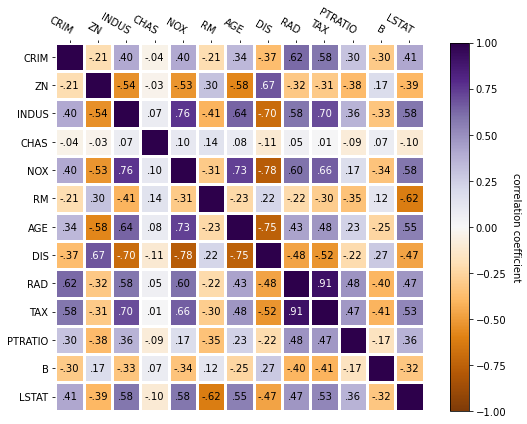

In [113]:
# Real correlation matrix
corr_coeff = calculate_corr_coef(cov_mat_ij)
plot_corr_matrix(corr_coeff, dataset['feature_names'])

### Correlation matrix interpretation
In the correlation matrix, all the values above 0.65 and below -0.65 are in *white* color so that we can distinguish them easily.

Because of strong correlations with other features, in this case we can remove the following features:
- NOX
- TAX
- DIS

In [114]:
def calculate_mse(split_train_data, split_test_data, split_train_target, split_test_target):
    """
    Returns the training and testing Mean Squared Error

    :param split_train_data: training input dataset
    :param split_test_data: testing input dataset
    :param split_train_target: training target dataset
    :param split_test_target: testing target dataset
    :return: training MSE and testing MSE as a tuple
    """
    # Perform least-squares method
    beta = (split_train_data.T @ split_train_data).inverse() @ split_train_data.T @ split_train_target

    # Calculating the MSE from training data and testing data
    train_mse = (((split_train_target - split_train_data @ beta) ** 2).sum() / split_train_target.size(0)).item()
    test_mse = (((split_test_target - split_test_data @ beta) ** 2).sum() / split_test_target.size(0)).item()
    return train_mse, test_mse

In [115]:
def print_mse(train_mse, test_mse, additional_text=''):
    print(f'*\tMSE metrics {additional_text}\t*\n'
          '*\t*****\t*****\t*****\t*****\t*****\t*****\t*****\t*')
    print(f'*\t\tTrain MSE:\t{train_mse}\t\t*\n*\t\tTest MSE:\t{test_mse}\t\t*\n'
          f'*\t******\t******\t******\t******\t******\t******\t******\t*')

In [116]:
# Perform MSE calculation without removing the correlated features
train_mse, test_mse = calculate_mse(split_train_data, split_test_data, split_train_target, split_test_target)
print_mse(train_mse, test_mse, 'without removing correlated features')

*	MSE metrics without removing correlated features	*
*	*****	*****	*****	*****	*****	*****	*****	*
*		Train MSE:	24.354657976212387		*
*		Test MSE:	24.86811144795891		*
*	******	******	******	******	******	******	******	*


In [117]:
# Here we filter the original tensor by excluding the indices corresponding to the features NOX, TAX and DIS from the second dimension
tensor_filter = [i for i, item in enumerate(dataset['feature_names']) if
                 item != 'NOX' and item != 'TAX' and item != 'DIS']
filtered_tensor_train = split_train_data[:, tensor_filter]
filtered_tensor_test = split_test_data[:, tensor_filter]

In [118]:
# Calculating the MSE from training data and testing data
train_mse, test_mse = calculate_mse(filtered_tensor_train, filtered_tensor_test, split_train_target, split_test_target)
print_mse(train_mse, test_mse, 'after removing features: NOX, TAX and DIS')

*	MSE metrics after removing features: NOX, TAX and DIS	*
*	*****	*****	*****	*****	*****	*****	*****	*
*		Train MSE:	25.5833850663775		*
*		Test MSE:	27.031279643029034		*
*	******	******	******	******	******	******	******	*


## Correlation coefficients for the Extended Matrix (with the *targets*)

In [119]:
# Concatenate the target tensor to the data tensor
extended_data_tensor = torch.cat((split_train_data, split_train_target.view(-1, 1)), 1)

In [120]:
# Calculate the Covariance matrix
cov_mat_ij_extended = calculate_cov_mat(extended_data_tensor)

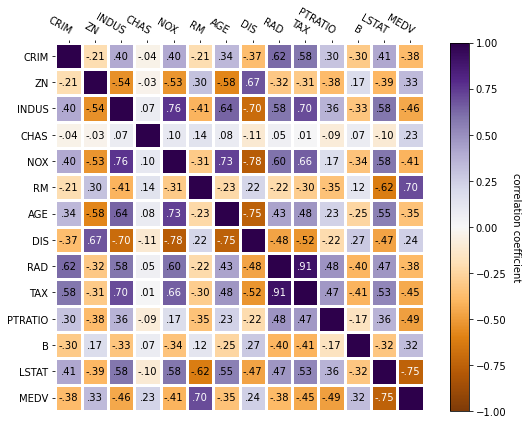

In [121]:
# Calculate the Correlation coefficient matrix
corr_coeff = calculate_corr_coef(cov_mat_ij_extended)
feature_names = np.concatenate((dataset['feature_names'], ('MEDV',)))
plot_corr_matrix(corr_coeff, feature_names)

In [122]:
# Perform MSE calculation after removing the strongest features correlated to MEDV: RM and LSTAT
tensor_filter = [i for i, item in enumerate(dataset['feature_names']) if item != 'RM' and item != 'LSTAT']
filtered_tensor_train = split_train_data[:, tensor_filter]
filtered_tensor_test = split_test_data[:, tensor_filter]
train_mse, test_mse = calculate_mse(filtered_tensor_train, filtered_tensor_test, split_train_target, split_test_target)
print_mse(train_mse, test_mse, 'after removing RM and LSTAT features')

*	MSE metrics after removing RM and LSTAT features	*
*	*****	*****	*****	*****	*****	*****	*****	*
*		Train MSE:	64.78500476286263		*
*		Test MSE:	56.48392784324082		*
*	******	******	******	******	******	******	******	*


# Principal Component Analysis
Here we'll use PCA to exclude linearly correlated features

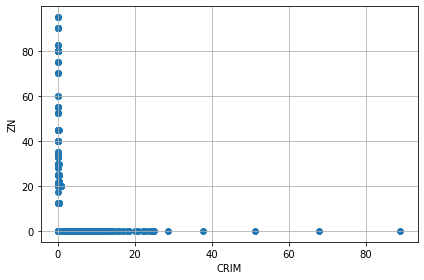

In [123]:
# Display scatter plot
plt.scatter(split_train_data[:, 0].to('cpu'), split_train_data[:, 1].to('cpu'))
plt.xlabel('CRIM')
plt.ylabel('ZN')
plt.grid()
plt.tight_layout()

In [124]:
# Calculate eigenvalues/eigenvectors for the Covariance matrix
eigen_val, eigen_vec = torch.linalg.eig(cov_mat_ij)

In [125]:
# Remove the imaginary part
real_eigen_val = eigen_val.real
real_eigen_vec = eigen_vec.real

In [126]:
# Calculate cumulative energy ratio
n_selection = 2
print(
    f'Cumulative energy ratio for {n_selection} principal components {(real_eigen_val[:n_selection].sum() / real_eigen_val.sum()).item()}')

Cumulative energy ratio for 2 principal components 0.9681967842995712


## PCA interpretation
We can see that by selecting only 2 principal components we have a cumulative energy ratio of ~0.97. So, it's safe to select just these 2 components. The PCA technique allowed us to reduce dimensions and still preserve the data's variation.

In [127]:
# Compute projected data matrix using the first 2 eigenvectors
projected_mat = centered_mat @ real_eigen_vec[:, :2]

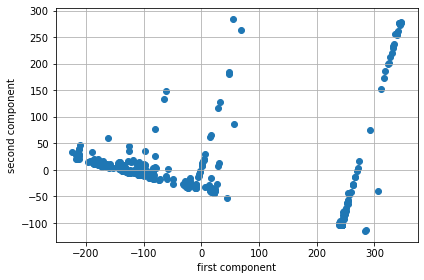

In [128]:
plt.scatter(projected_mat[:, 0].to('cpu'), projected_mat[:, 1].to('cpu'))
plt.xlabel('first component')
plt.ylabel('second component')
plt.grid()
plt.tight_layout()